# Diffusion Model

> Neural net modules

In [ ]:
#| default_exp models.diffusion

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms.v2 as transforms
from lightning import Trainer
import os
import logging
import warnings
from omegaconf import OmegaConf
from hydra.utils import instantiate
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import List, Optional, Callable, Any
from functools import partial


from matplotlib import pyplot as plt
import numpy as np

from nimrod.utils import get_device, set_seed, time_it
from nimrod.image.datasets import ImageDataset, show_images, make_grid
from nimrod.models.core import lr_finder, train_one_cycle, Regressor

import diffusers
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline, DDIMScheduler
from diffusers.utils import make_image_grid
from diffusers.optimization import get_cosine_schedule_with_warmup

set_seed(42)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.image")

Seed set to 42


## Noise Scheduler

In [ ]:
NOISE_TIME_STEPS = 10
noise_scheduler = DDPMScheduler(
    num_train_timesteps=NOISE_TIME_STEPS,
    beta_schedule="squaredcos_cap_v2" # beter for small img sizes
    )

### Usage

xb: torch.Size([100, 3, 32, 32])
noise: torch.Size([100, 3, 32, 32])
time_steps: torch.Size([100])
noisy_images: torch.Size([100, 3, 32, 32])


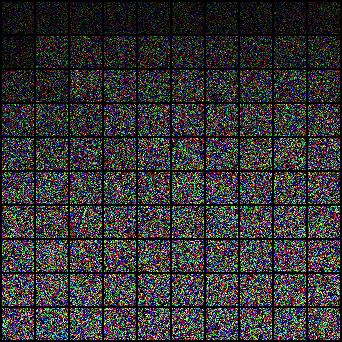

In [ ]:
B, C, H, W = 100, 3, 32, 32
xb = torch.zeros((B,C,H,W))
print(f"xb: {xb.shape}")
noise = torch.randn(xb.shape)
print(f"noise: {noise.shape}")
time_steps = torch.linspace(0, NOISE_TIME_STEPS-1, B).long()
# time_steps = torch.randint(0, NOISE_TIME_STEPS, (B,))
print(f"time_steps: {time_steps.shape}")
noisy_images = noise_scheduler.add_noise(xb, noise, time_steps)
print(f"noisy_images: {noisy_images.shape}")
show_images(noisy_images, ncols=10)

## U-Net: Noise prediction

In [ ]:
B,C,H,W = xb.shape

model = UNet2DModel(
    sample_size=H,
    in_channels=C, 
    out_channels=C, 
    block_out_channels=(32, 64, 128, 256)
    )

### Usage

torch.Size([100, 3, 32, 32]) torch.Size([100])


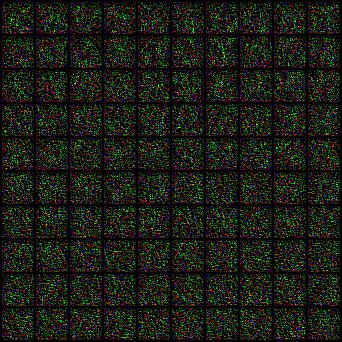

In [ ]:
print(noisy_images.shape, time_steps.shape)
with torch.no_grad():
    noise_pred = model(noisy_images, time_steps).sample

show_images(noise_pred, ncols=10)

## Training

### Data

[22:28:16] INFO - Init ImageDataModule for mnist


/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'transforms' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transforms'])`.
[22:28:18] INFO - loading dataset mnist with args () from split train
[22:28:18] INFO - loading dataset mnist from split train
Overwrite dataset info from restored data version if exists.
[22:28:19] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c
[22:28:19] INFO - Loading Dataset info from ../data/image/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c
Found cached dataset mnist (/user/s/slegroux/Projects/nimrod/nbs/../data/image/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c)
[22:28:19] INFO - Found cached dataset mnist (/user/s/slegroux/Projects/nimrod

num_classes: 10, batch_size: 512
labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
X: torch.Size([1, 32, 32]), Y: 7
X: torch.Size([512, 1, 32, 32]), Y: torch.Size([512])


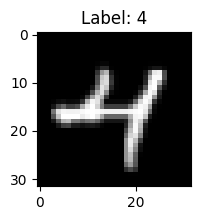

In [ ]:
#| no test

BATCH_SIZE = 512

cfg = OmegaConf.load('../config/data/image/mnist.yaml')
tfs = transforms.Compose(
    [transforms.ToImage(),
    transforms.Resize(32),
    # transforms.Normalize((0.1307,), (0.3081,))
    ]
    )

dm = instantiate(cfg, batch_size=BATCH_SIZE, transforms=tfs, num_workers=20)
dm.prepare_data()
dm.setup()

# check properties
print(f"num_classes: {dm.num_classes}, batch_size: {dm.batch_size}")
print(f"labels: {dm.label_names}")

# sample
x, y = dm.test_ds[0]
print(f"X: {x.shape}, Y: {y}")

# batch
xb,yb = next(iter(dm.train_dataloader()))
print(f"X: {xb.shape}, Y: {yb.shape}")
B,C,H,W = xb.shape
dm.show(0)


### Noise Scheduler / "noisifier"

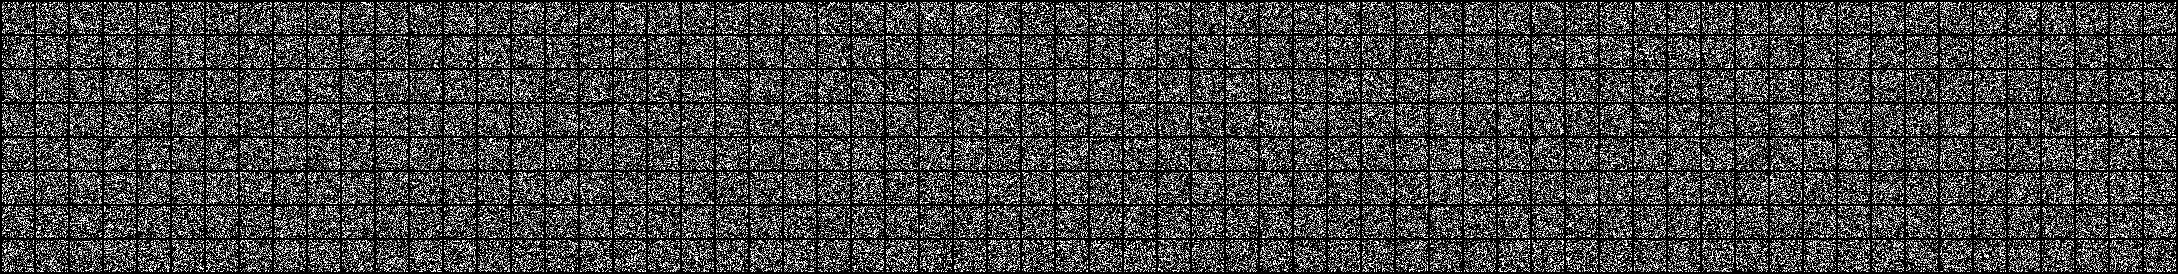

In [ ]:
#| notest

NOISE_TIME_STEPS = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=NOISE_TIME_STEPS,
    beta_schedule="squaredcos_cap_v2" # beter for small img sizes
    )

B,C,H,W = xb.shape

model = UNet2DModel(
    sample_size=H,
    in_channels=C, 
    out_channels=C, 
    block_out_channels=(32, 64, 128, 256)
    )
# generate gaussian noise images of shape (B, C, H, W)
noise = torch.randn(xb.shape)
# generate different time steps for each image in batch
time_steps = torch.linspace(0, NOISE_TIME_STEPS-1, B).long()
# generate more or less noise from scheduler depending on time step
noisy_images = noise_scheduler.add_noise(xb, noise, time_steps)
show_images(noisy_images, ncols=64)

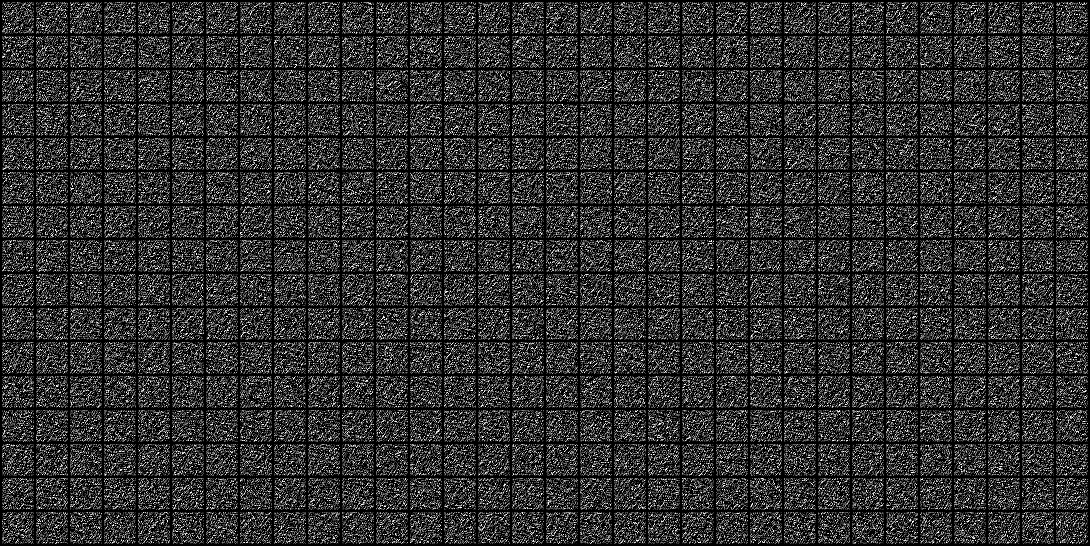

In [ ]:
#| notest

# predict noise from noisy image at time_step
with torch.no_grad():
    noise_pred = model(noisy_images, time_steps).sample

show_images(noise_pred, ncols=32)

### LR scheduler & optimizer

In [ ]:
#| notest

device = get_device()
print(f"device: {device}")

NOISE_TIME_STEPS = 1000
NUM_EPOCHS = 1
lr = 1e-4
lr_warmup_steps = 500
# total steps =number of batches * num_epochs
num_training_steps = len(dm.train_dataloader()) * NUM_EPOCHS
print(f"num_training_steps: {num_training_steps}")

model = UNet2DModel(
    sample_size=H,
    in_channels=C,
    out_channels=C,
    block_out_channels=(32, 64, 128, 256)
    )

model.to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=NOISE_TIME_STEPS)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

criterion = nn.MSELoss()

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=num_training_steps
)


[22:30:10] INFO - Using device: cuda


device: cuda
num_training_steps: 94


### Training Loop

In [ ]:
#| notest

train_step_losses = []
val_step_losses = []
lrs = []

for epoch in range(NUM_EPOCHS):
    i = 0
    model.train()
    n_steps, total_loss = 0, 0

    for step, (images, labels) in tqdm(enumerate(dm.train_dataloader()), total=len(dm.train_dataloader()), leave=False):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        B, C, H, W = images.shape
        # sample noise
        noise = torch.randn(images.shape).to(device)
        # sample random timesteps
        # timesteps = torch.randint(0, NOISE_TIME_STEPS, (images.shape[0],)).to(device)
        timesteps = torch.randint(0, NOISE_TIME_STEPS, (B,)).to(device)
        # create noisy image at timestep with noise scheduler
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)

        # train model to predict noise
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        # output should be as close to input as possible
        loss = criterion(noise_pred, noise)
        n_steps += len(images)
        total_loss += (loss.item() * len(images))
        train_step_losses.append(loss.item())
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        # logger.info(f"loss.item(): {loss.item()}, len(images): {len(images)}")
        # logger.info(f"Epoch: {epoch}, step: {step}, n_steps: {n_steps}, loss: {loss.item()}")
        loss.backward()
        optimizer.step()
        lr_scheduler.step()


    logger.info(f"Epoch: {epoch} train_loss: {total_loss / n_steps}")

    model.eval()
    total_loss, n_steps = 0, 0
    for step, (images, labels) in tqdm(enumerate(dm.val_dataloader()), total=len(dm.val_dataloader()), leave=False):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        # sample noise
        noise = torch.randn(images.shape).to(device)
        # sample random timesteps
        timesteps = torch.randint(0, NOISE_TIME_STEPS, (images.shape[0],)).to(device)
        # create noisy image at timestep with noise scheduler
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
        # train model to predict noise
        outputs = model(noisy_images, timesteps, return_dict=False)[0]
        # output should be as close to input as possible

        loss = criterion(outputs, noise)
        val_step_losses.append(loss.item())
        n_steps += len(images) # bs
        total_loss += loss.item() * len(images)
        # logger.info(f"Epoch: {epoch}, step: {step}, n_steps: {n_steps}, loss: {loss.item()}")
    logger.info(f"Epoch: {epoch} val_loss: {total_loss / n_steps}") 


  0%|          | 0/94 [00:00<?, ?it/s]

/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
[22:15:30] INFO - Epoch: 0 train_loss: 0.7241547261873881


  0%|          | 0/24 [00:00<?, ?it/s]

[22:15:32] INFO - Epoch: 0 val_loss: 0.3778018388748169


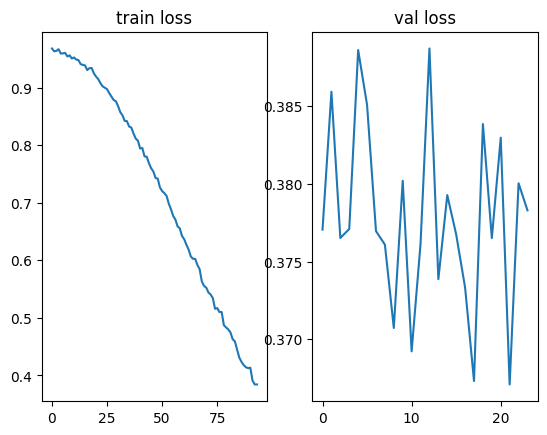

In [ ]:
#| notest

fig, axs = plt.subplots(1,2)
axs[0].plot(train_step_losses)
axs[0].set_title("train loss")
axs[1].plot(val_step_losses)
axs[1].set_title("val loss")
# axs[2].plot(lrs)
# axs[2].set_title("learning rate")
plt.show()

### Test Image Generation

  0%|          | 0/1000 [00:00<?, ?it/s]

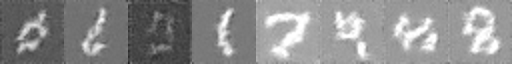

In [ ]:
#| notest

# Using pre-defined HF pipeline
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler).to(device)
img_gen = pipeline(batch_size=8)
make_grid(img_gen.images)

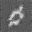

In [ ]:
#| notest
img_gen.images[0]


In [ ]:
#| notest

# use our own sampler based on noise_scheduler

@time_it
def generate_image(model, images_shape, device, noise_scheduler):
    # start with noise images (B,C,H,W)
    sample = torch.randn(images_shape).to(device)
    for i, t in enumerate(noise_scheduler.timesteps):
        with torch.no_grad():
            # predict noise 
            residual = model(sample, t).sample
            # update sample with step
            sample = noise_scheduler.step(residual, t, sample).prev_sample


    # sample = (sample / 2 + 0.5).clamp(0, 1)
    return sample

        # plt.imshow(image[0].permute(1,2,0).cpu().numpy())

In [ ]:
#| notest
images = generate_image(model, (B,C,H,W), device, noise_scheduler)

generate_image: 43.519 seconds


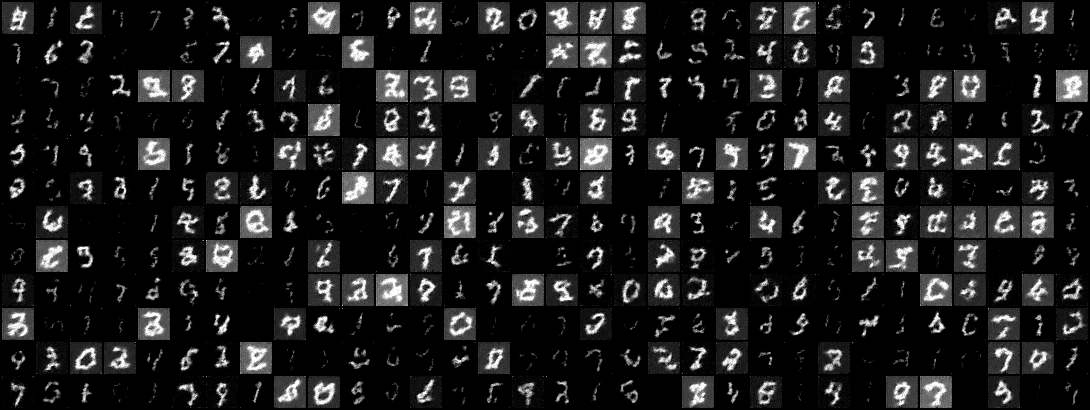

In [ ]:
#| notest
show_images(images, ncols=32)

## DiffusorX
Diffussor is basically a noise regressor

In [ ]:
#| export 

class DiffusorX(Regressor):
    def __init__(
        self,
        nnet: diffusers.UNet2DModel,
        noise_scheduler: diffusers.DDPMScheduler,
        optimizer:Callable[...,torch.optim.Optimizer], # optimizer,
        scheduler: Optional[Callable[...,Any]]=None, # scheduler
    ):
        super().__init__(
            nnet=nnet,
            optimizer=optimizer,
            scheduler=scheduler
        )
        
        self.noise_scheduler = noise_scheduler
        self.nnet = nnet
        logger.info("DiffusionX: init")
    
    def forward(
        self,
        x:torch.Tensor, # noisy image
        t:torch.Tensor # time step
        )->torch.Tensor: # noise estimate
        return self.nnet(x, t).sample

    def _step(self, batch, batch_idx):
        # logger.log("step!")
        x, y = batch # x: clean image, y: label
        B, C, H, W = x.shape
        # linspace?
        # t = torch.linspace(0, self.noise_scheduler.config.num_train_timesteps -1, (B,)).long() # dim (B)
        t = torch.randint(0, self.noise_scheduler.config.num_train_timesteps, (B,)).to(self.device) # dim (B))
        noise =  torch.randn(x.shape).to(self.device) # B,C,H,W
        # self.noise_scheduler = self.noise_scheduler.to(self.device)
        noisy_img = self.noise_scheduler.add_noise(x, noise, t) # 
        noise_pred = self.forward(noisy_img, t)
        loss = self.criterion(noise_pred, noise)
        return loss, noise_pred, noise # loss, y_hat, y

    def generate_images(self, img_shape):
        logger.info("diffuse a batch")
        B, C, H, W = img_shape
        sample = torch.randn(img_shape).to(self.device)
        for i, t in enumerate(self.noise_scheduler.timesteps):
            with torch.no_grad():
                residual = self.forward(sample, t)
                sample = self.noise_scheduler.step(residual, t, sample).prev_sample
        return sample

In [ ]:
B, C, H, W = 16, 1, 32, 32

optimizer = partial(torch.optim.AdamW, lr=3e-4)

nnet = UNet2DModel(
    sample_size=H,
    in_channels=C,
    out_channels=C,
    block_out_channels=(32, 64, 128, 256)
    )

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
)

print(f"steps: {noise_scheduler.config.num_train_timesteps}")
model = DiffusorX(nnet, noise_scheduler, optimizer)
x = torch.randn((B, C, H, W))

t = torch.randint(0, noise_scheduler.config.num_train_timesteps, (B,))
print(f"x:{x.shape}, t: {t.shape}, {type(t)}")
noise = nnet(x, t).sample
print(noise.shape)
print(model(x, t).shape)



[22:30:19] INFO - Regressor: init
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
[22:30:19] INFO - DiffusionX: init


steps: 1000
x:torch.Size([16, 1, 32, 32]), t: torch.Size([16]), <class 'torch.Tensor'>
torch.Size([16, 1, 32, 32])
torch.Size([16, 1, 32, 32])


In [ ]:
#| notest
model = model.to(device)
imgs = model.generate_images(x.shape)

[22:31:00] INFO - diffuse a batch


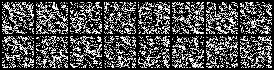

In [ ]:
#| notest
show_images(imgs, ncols=8)

In [ ]:
#| notest
torch.set_float32_matmul_precision("medium")

cfg = OmegaConf.load('../config/model/image/diffusorx.yaml')
optim = partial(torch.optim.AdamW, lr=3e-4)
model = instantiate(cfg)(optimizer= optim)

total_time_steps = model.noise_scheduler.config.num_train_timesteps
x = torch.randn((B, C, H, W)) #.to('mps')
t = torch.randint(0, total_time_steps, (B,)) #.to('mps')

print(model(x, t).shape)


[22:32:21] INFO - Regressor: init
[22:32:21] INFO - DiffusionX: init


torch.Size([16, 1, 32, 32])


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()